In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/CAvideos.csv
/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/GB_category_id.json


In [2]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline


from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
import string
import random
import operator
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
import nltk


# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# keras module for building LSTM 
#from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.preprocessing.text import Tokenizer
#from keras.callbacks import EarlyStopping
#from keras.models import Sequential
#import keras.utils as ku 
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
# set seeds for reproducability
from numpy.random import seed
seed(1)

import warnings
warnings.filterwarnings("ignore")

print(os.listdir("../input/youtube-new"))

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


['USvideos.csv', 'MXvideos.csv', 'RU_category_id.json', 'JPvideos.csv', 'JP_category_id.json', 'RUvideos.csv', 'FRvideos.csv', 'DE_category_id.json', 'MX_category_id.json', 'IN_category_id.json', 'CAvideos.csv', 'GBvideos.csv', 'FR_category_id.json', 'CA_category_id.json', 'KRvideos.csv', 'DEvideos.csv', 'INvideos.csv', 'KR_category_id.json', 'US_category_id.json', 'GB_category_id.json']


In [3]:
#Only importing english speaking countries' datasets as that is what we had decided to focus on out of convenience for text analysis.

GB = pd.read_csv("../input/youtube-new/GBvideos.csv")
CA = pd.read_csv("../input/youtube-new/CAvideos.csv")
US = pd.read_csv("../input/youtube-new/USvideos.csv")
US_test = pd.read_csv("../input/youtube-new/USvideos.csv")


In [4]:
US_category_id = {}
CA_category_id = {}
GB_category_id = {}

with open('../input/youtube-new/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        US_category_id[category['id']] = category['snippet']['title']
        
with open('../input/youtube-new/CA_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        CA_category_id[category['id']] = category['snippet']['title']

with open('../input/youtube-new/GB_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        GB_category_id[category['id']] = category['snippet']['title']



In [5]:
#combining all english speaking countries into one main DataFrame called ENG_df
ENG_df =pd.concat([GB, CA, US])
ENG_df.shape

#formatting date and time, and splitting publish_time into two separate cols publish date and publish time
ENG_df['publish_time'] = pd.to_datetime(ENG_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

ENG_df = ENG_df[ENG_df['trending_date'].notnull()]
ENG_df = ENG_df[ENG_df['publish_time'].notnull()]

ENG_df.insert(4, 'publish_date', ENG_df['publish_time'].dt.date)
ENG_df['publish_time'] = ENG_df['publish_time'].dt.time

#splitting publish_time column into separate hour, minute and second columns
ENG_df['publish_time'] = ENG_df['publish_time'].astype(str)
ENG_df[['hour','minute','second']] = ENG_df.publish_time.str.split(":", expand=True).astype(int)


#adding a column which represents number of days a video remained on trending, 
#simply by counting instances of each video_id, as each entry represents a day on trending
occurances = ENG_df.groupby(['video_id']).size()
days_trending = occurances.to_frame(name = 'days_trending').reset_index()
#ENG_df['days_trending'] = ENG_df.groupby('video_id').cumcount()

#introduce a like_rate, comment_rate, dislike_rate.
ENG_df['like_rate'] = ENG_df['likes']/ENG_df['views']*100
ENG_df['dislike_rate'] = ENG_df['dislikes']/ENG_df['views']*100
ENG_df['comment_rate'] = ENG_df['comment_count']/ENG_df['views']*100

ENG_df_merge = pd.merge(left=ENG_df, right=days_trending, left_on='video_id', right_on='video_id', how='outer')

# _last consists only of the last entry of each unique video_id, to have the numeric data of a video on it's last day on trending.
# _first consists only of the first entry of each unique video_id, to have the numeric data of a video on it's first day on trending.
ENG_df_merge_last = ENG_df_merge.drop_duplicates(['video_id'], keep='last')
ENG_df_merge_first = ENG_df_merge.drop_duplicates(['video_id'], keep='first')

ENG_df.set_index(['trending_date','video_id'], inplace= True)
ENG_df_merge.set_index(['trending_date', 'video_id'], inplace=True)


ENG_df_merge_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                30318 non-null  object 
 1   trending_date           30318 non-null  object 
 2   title                   30318 non-null  object 
 3   channel_title           30318 non-null  object 
 4   publish_date            30318 non-null  object 
 5   category_id             30318 non-null  int64  
 6   publish_time            30318 non-null  object 
 7   tags                    30318 non-null  object 
 8   views                   30318 non-null  int64  
 9   likes                   30318 non-null  int64  
 10  dislikes                30318 non-null  int64  
 11  comment_count           30318 non-null  int64  
 12  thumbnail_link          30318 non-null  object 
 13  comments_disabled       30318 non-null  bool   
 14  ratings_disabled        30318 non-nul

In [6]:
#will do selectKBest with f_regressor on _first and _last instance of a videos appearance on trending
#comparing if features which determine it's longevity on trending are consistent across it's lifetime, from start to end.

#selecting features to consider for X_first as: views, likes dislikes, comment_count, hour of publish, minute of publish and second of publish.
X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_first = ENG_df_merge_first.iloc[:,-1]

#print(X_first.head)
#print(Y_first.head)

X_last = ENG_df_merge_last.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_last = ENG_df_merge_last.iloc[:,-1]

print(X_last.head)
print(Y_last.head)

<bound method NDFrame.head of            views   likes  dislikes  comment_count  hour  minute  second  \
17       8041928   60434     11437           7545     7      38      29   
20       1776127   35741      3214           3585     6      24      44   
43      26448434  911883     53873         127481    17       0       3   
57         98507     424        44             54     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120741    483029   30127       237            915    13      48      29   
120742   1549110   21905      1516           1318     1      31      53   
120743   2183462   79677      2034           3464     3      27      30   
120744    607422   26166       895           3517    18      55      26   
120745    296295    8157       294            764     9       0       6   

        like_rate  dislike_rate  comment_rate  
17       0.751486    

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [8]:
first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_first_new = first_selector.fit_transform(X_first, Y_first)
print(X_first_new[:5])
print(X_first)

scores_first_new = pd.DataFrame({'Variable' : X_first.columns, 'Score': first_selector.scores_})
p_value_first = pd.DataFrame({'Variable' : X_first.columns, 'p values' : first_selector.pvalues_})

print(scores_first_new)

'''Selecting best 5 features, it can be noted that, from the first instance on trending (first appearance) that the views, likes, dislikes, comment count 
and like_rate are most important.'''


[[7.22451500e+06 5.56810000e+04 1.02470000e+04 9.47900000e+03
  7.70723017e-01]
 [1.05363200e+06 2.55610000e+04 2.29400000e+03 2.75700000e+03
  2.42598934e+00]
 [1.71585790e+07 7.87420000e+05 4.34200000e+04 1.25882000e+05
  4.58907465e+00]
 [2.78330000e+04 1.93000000e+02 1.20000000e+01 3.70000000e+01
  6.93421478e-01]
 [9.81500000e+03 3.00000000e+01 2.00000000e+00 3.00000000e+01
  3.05654610e-01]]
           views   likes  dislikes  comment_count  hour  minute  second  \
0        7224515   55681     10247           9479     7      38      29   
18       1053632   25561      2294           2757     6      24      44   
21      17158579  787420     43420         125882    17       0       3   
44         27833     193        12             37     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120740    279728   19691       135            579    13      48      29   

'Selecting best 5 features, it can be noted that, from the first instance on trending (first appearance) that the views, likes, dislikes, comment count \nand like_rate are most important.'

In [9]:
last_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_last_new = last_selector.fit_transform(X_last, Y_last)

scores_last_new = pd.DataFrame({'Variable' : X_last.columns, 'Score': last_selector.scores_})
print(X_last_new[:5])
print(X_last)

print(scores_last_new)

'''
From the scores table it can be seen which features have the highest score, and therefore impact on the total number of days a video appears 
on the trending page. This is representative of the videos on their last appearance on trending, and shows that - in order -
views,likes, dislikes, comment_count, and hour of upload are the 5 best features. 
'''

[[8.04192800e+06 6.04340000e+04 1.14370000e+04 7.54500000e+03
  7.51486459e-01]
 [1.77612700e+06 3.57410000e+04 3.21400000e+03 3.58500000e+03
  2.01229980e+00]
 [2.64484340e+07 9.11883000e+05 5.38730000e+04 1.27481000e+05
  3.44777691e+00]
 [9.85070000e+04 4.24000000e+02 4.40000000e+01 5.40000000e+01
  4.30426264e-01]
 [9.81500000e+03 3.00000000e+01 2.00000000e+00 3.00000000e+01
  3.05654610e-01]]
           views   likes  dislikes  comment_count  hour  minute  second  \
17       8041928   60434     11437           7545     7      38      29   
20       1776127   35741      3214           3585     6      24      44   
43      26448434  911883     53873         127481    17       0       3   
57         98507     424        44             54     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120741    483029   30127       237            915    13      48      29   

'\nFrom the scores table it can be seen which features have the highest score, and therefore impact on the total number of days a video appears \non the trending page. This is representative of the videos on their last appearance on trending, and shows that - in order -\nviews,likes, dislikes, comment_count, and hour of upload are the 5 best features. \n'

In [10]:
#look at which features typically lead to shortest time between publish date and first trending date.

ENG_df_merge_first['publish_date'] = pd.to_datetime(ENG_df_merge_first['publish_date'])
ENG_df_merge_first['trending_date'] = pd.to_datetime(ENG_df_merge_first['trending_date'], format="%y.%d.%m")

ENG_df_merge_first['days_to_trending'] = (ENG_df_merge_first['trending_date'] - ENG_df_merge_first['publish_date'])

ENG_df_merge_first['days_to_trending'] = ENG_df_merge_first['days_to_trending'].dt.days.astype(int)

print(ENG_df_merge_first.info())

print(ENG_df_merge_first.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                30318 non-null  object        
 1   trending_date           30318 non-null  datetime64[ns]
 2   title                   30318 non-null  object        
 3   channel_title           30318 non-null  object        
 4   publish_date            30318 non-null  datetime64[ns]
 5   category_id             30318 non-null  int64         
 6   publish_time            30318 non-null  object        
 7   tags                    30318 non-null  object        
 8   views                   30318 non-null  int64         
 9   likes                   30318 non-null  int64         
 10  dislikes                30318 non-null  int64         
 11  comment_count           30318 non-null  int64         
 12  thumbnail_link          30318 non-null  objec

In [11]:
#observing feature which influence days trending most. considering number of days between publish date and trending date.
X_diff = X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22,24]]
Y_diff = ENG_df_merge_first.iloc[:,23]

print(X_diff.info())
print(Y_diff)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   views             30318 non-null  int64  
 1   likes             30318 non-null  int64  
 2   dislikes          30318 non-null  int64  
 3   comment_count     30318 non-null  int64  
 4   hour              30318 non-null  int64  
 5   minute            30318 non-null  int64  
 6   second            30318 non-null  int64  
 7   like_rate         30318 non-null  float64
 8   dislike_rate      30318 non-null  float64
 9   comment_rate      30318 non-null  float64
 10  days_to_trending  30318 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.8 MB
None
0         18
18         3
21        23
44        14
58         1
          ..
120740     2
120742     1
120743     1
120744     1
120745     1
Name: days_trending, Length: 30318, dtype: int64


In [12]:
diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_diff_new = diff_selector.fit_transform(X_diff, Y_diff)

scores_diff_new = pd.DataFrame({'Variable' : X_diff.columns, 'Score': diff_selector.scores_})

In [13]:
print(X_diff_new)
print(X_diff.head(5))
print(scores_diff_new)
'''
The best features for predicting the number of days a video remains on trending is the same as previous SelectKBest runs.
'''

[[7.2245150e+06 5.5681000e+04 1.0247000e+04 9.4790000e+03 4.0000000e+00]
 [1.0536320e+06 2.5561000e+04 2.2940000e+03 2.7570000e+03 2.0000000e+00]
 [1.7158579e+07 7.8742000e+05 4.3420000e+04 1.2588200e+05 4.0000000e+00]
 ...
 [2.1834620e+06 7.9677000e+04 2.0340000e+03 3.4640000e+03 1.0000000e+00]
 [6.0742200e+05 2.6166000e+04 8.9500000e+02 3.5170000e+03 2.0000000e+00]
 [2.9629500e+05 8.1570000e+03 2.9400000e+02 7.6400000e+02 1.0000000e+00]]
       views   likes  dislikes  comment_count  hour  minute  second  \
0    7224515   55681     10247           9479     7      38      29   
18   1053632   25561      2294           2757     6      24      44   
21  17158579  787420     43420         125882    17       0       3   
44     27833     193        12             37     2      30      38   
58      9815      30         2             30     1      45      13   

    like_rate  dislike_rate  comment_rate  days_to_trending  
0    0.770723      0.141837      0.131206                 4  
18   

'\nThe best features for predicting the number of days a video remains on trending is the same as previous SelectKBest runs.\n'

In [14]:
#trying to see what influences how quickly the video made it to trending
X_diff_2 = X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_diff_2 = ENG_df_merge_first.iloc[:,24]

print(X_diff_2.info())
print(Y_diff_2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   views          30318 non-null  int64  
 1   likes          30318 non-null  int64  
 2   dislikes       30318 non-null  int64  
 3   comment_count  30318 non-null  int64  
 4   hour           30318 non-null  int64  
 5   minute         30318 non-null  int64  
 6   second         30318 non-null  int64  
 7   like_rate      30318 non-null  float64
 8   dislike_rate   30318 non-null  float64
 9   comment_rate   30318 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 2.5 MB
None
0         4
18        2
21        4
44        1
58        1
         ..
120740    1
120742    0
120743    1
120744    2
120745    1
Name: days_to_trending, Length: 30318, dtype: int64


In [15]:
diff_2_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_diff_2_new = diff_2_selector.fit_transform(X_diff_2, Y_diff_2)

scores_diff2_new = pd.DataFrame({'Variable' : X_diff_2.columns, 'Score': diff_2_selector.scores_})

In [16]:
print(X_diff_2_new)
print(X_diff_2.head(5))
print(scores_diff2_new)

[[7.22451500e+06 5.56810000e+04 7.00000000e+00 7.70723017e-01
  1.31206039e-01]
 [1.05363200e+06 2.55610000e+04 6.00000000e+00 2.42598934e+00
  2.61666312e-01]
 [1.71585790e+07 7.87420000e+05 1.70000000e+01 4.58907465e+00
  7.33638840e-01]
 ...
 [2.18346200e+06 7.96770000e+04 3.00000000e+00 3.64911320e+00
  1.58647139e-01]
 [6.07422000e+05 2.61660000e+04 1.80000000e+01 4.30771358e+00
  5.79004382e-01]
 [2.96295000e+05 8.15700000e+03 9.00000000e+00 2.75299954e+00
  2.57851128e-01]]
       views   likes  dislikes  comment_count  hour  minute  second  \
0    7224515   55681     10247           9479     7      38      29   
18   1053632   25561      2294           2757     6      24      44   
21  17158579  787420     43420         125882    17       0       3   
44     27833     193        12             37     2      30      38   
58      9815      30         2             30     1      45      13   

    like_rate  dislike_rate  comment_rate  
0    0.770723      0.141837      0.131206  

Above shows that, the features which influence how QUICK a video makes it to trending (shortest number of days between publish date and first trending date) are (in order starting with most relevant):
1. comment_rate
2. like_rate
3. hour uploaded
4. dislike_rate

I have ignored number of likes and views despite their higher scores due to the fact that the DataFrame consisted only of the first entry of each video. The number of views a video has when it first appears on trending has nothing to do with predicting whether or not it reaches trending because this can only be known after the fact. However, like rate, comment rate, dislike rate and hour uploaded can all be observed prior to the first appearance of a video on the trending page, and can therefore give a better idea to the content creater how their video is performing relative to previous videos which appeared on trending. 

I believe that, given more data prior to the initial trending date, if we were able to observe the rate of increase of views, that would be an important feature to consider

In [17]:
corr_matrix = ENG_df[0:-1].corr()
print(corr_matrix)

                        category_id     views     likes  dislikes  \
category_id                1.000000 -0.174770 -0.192535 -0.038733   
views                     -0.174770  1.000000  0.788391  0.410972   
likes                     -0.192535  0.788391  1.000000  0.451226   
dislikes                  -0.038733  0.410972  0.451226  1.000000   
comment_count             -0.081226  0.494116  0.771322  0.735224   
comments_disabled          0.036668 -0.000541 -0.030477 -0.005800   
ratings_disabled          -0.019386  0.011644 -0.024946 -0.009618   
video_error_or_removed    -0.021993  0.009294  0.007100  0.007907   
hour                       0.100706 -0.073277 -0.061666 -0.010808   
minute                     0.057099 -0.052647 -0.079787  0.017740   
second                     0.056653 -0.043238 -0.071125  0.007071   
like_rate                 -0.039467 -0.066746  0.129656 -0.008853   
dislike_rate               0.043247 -0.006047  0.014209  0.241745   
comment_rate               0.10540

<IPython.core.display.Javascript object>


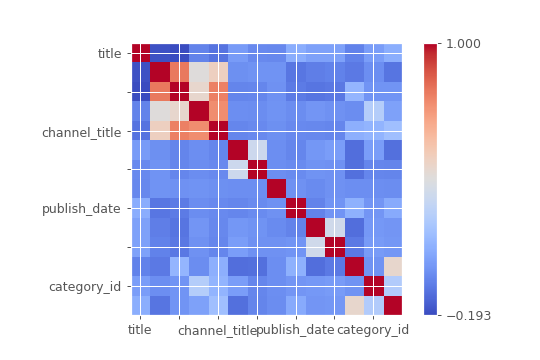

In [18]:
fig, ax = plt.subplots()

heatmap = ax.imshow(corr_matrix, interpolation='nearest', cmap=cm.coolwarm)

cbar_min = corr_matrix.min().min()
cbar_max = corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

labels=['']
for column in ENG_df[0:-1]:
    labels.append(column)
    labels.append('')
ax.set_yticklabels(labels,minor=False)
ax.set_xticklabels(labels, minor=False)

plt.show()

In [19]:
ENG_df['category_name'] = np.nan

ENG_df.loc[(ENG_df["category_id"] == 1),"category_name"] = 'Film and Animation'
ENG_df.loc[(ENG_df["category_id"] == 2),"category_name"] = 'Autos & Vehicles'
ENG_df.loc[(ENG_df["category_id"] == 10),"category_name"] = 'Music'
ENG_df.loc[(ENG_df["category_id"] == 15),"category_name"] = 'Pets and Animals'
ENG_df.loc[(ENG_df["category_id"] == 17),"category_name"] = 'Sport'
ENG_df.loc[(ENG_df["category_id"] == 18),"category_name"] = 'Short Movies'
ENG_df.loc[(ENG_df["category_id"] == 19),"category_name"] = 'Travel and Events'
ENG_df.loc[(ENG_df["category_id"] == 20),"category_name"] = 'Gaming'
ENG_df.loc[(ENG_df["category_id"] == 21),"category_name"] = 'Videoblogging'
ENG_df.loc[(ENG_df["category_id"] == 22),"category_name"] = 'People & Blogs'
ENG_df.loc[(ENG_df["category_id"] == 23),"category_name"] = 'Comedy'
ENG_df.loc[(ENG_df["category_id"] == 24),"category_name"] = 'Entertainment'
ENG_df.loc[(ENG_df["category_id"] == 25),"category_name"] = 'News and Politics'
ENG_df.loc[(ENG_df["category_id"] == 26),"category_name"] = 'How to & Style'
ENG_df.loc[(ENG_df["category_id"] == 27),"category_name"] = 'Education'
ENG_df.loc[(ENG_df["category_id"] == 28),"category_name"] = 'Science and Technology'
ENG_df.loc[(ENG_df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
ENG_df.loc[(ENG_df["category_id"] == 30),"category_name"] = 'Movies'
ENG_df.loc[(ENG_df["category_id"] == 31),"category_name"] = 'Anime/Animation'
ENG_df.loc[(ENG_df["category_id"] == 32),"category_name"] = 'Action/Adventure'
ENG_df.loc[(ENG_df["category_id"] == 33),"category_name"] = 'Classics'
ENG_df.loc[(ENG_df["category_id"] == 34),"category_name"] = 'Comedy'
ENG_df.loc[(ENG_df["category_id"] == 35),"category_name"] = 'Documentary'
ENG_df.loc[(ENG_df["category_id"] == 36),"category_name"] = 'Drama'
ENG_df.loc[(ENG_df["category_id"] == 37),"category_name"] = 'Family'
ENG_df.loc[(ENG_df["category_id"] == 38),"category_name"] = 'Foreign'
ENG_df.loc[(ENG_df["category_id"] == 39),"category_name"] = 'Horror'
ENG_df.loc[(ENG_df["category_id"] == 40),"category_name"] = 'Sci-Fi/Fantasy'
ENG_df.loc[(ENG_df["category_id"] == 41),"category_name"] = 'Thriller'
ENG_df.loc[(ENG_df["category_id"] == 42),"category_name"] = 'Shorts'
ENG_df.loc[(ENG_df["category_id"] == 43),"category_name"] = 'Shows'
ENG_df.loc[(ENG_df["category_id"] == 44),"category_name"] = 'Trailers'


<IPython.core.display.Javascript object>


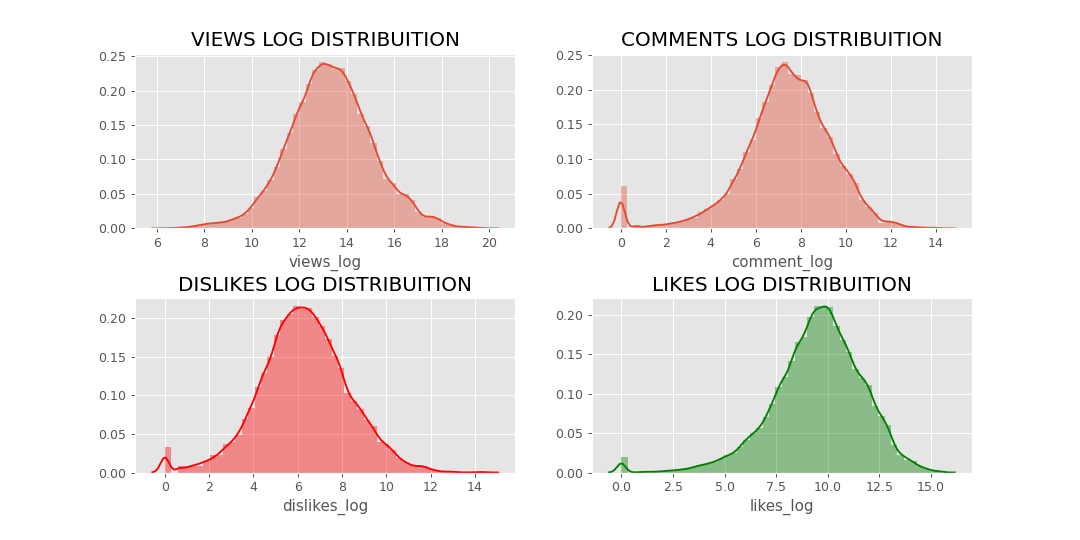

'\nViews, Comments, Dislikes and Likes are all normally distributed.\n'

In [20]:
ENG_df['likes_log'] = np.log(ENG_df['likes'] + 1)
ENG_df['views_log'] = np.log(ENG_df['views'] + 1)
ENG_df['dislikes_log'] = np.log(ENG_df['dislikes'] + 1)
ENG_df['comment_log'] = np.log(ENG_df['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(ENG_df['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(ENG_df['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(ENG_df['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(ENG_df['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

'''
Views, Comments, Dislikes and Likes are all normally distributed.
'''

<IPython.core.display.Javascript object>


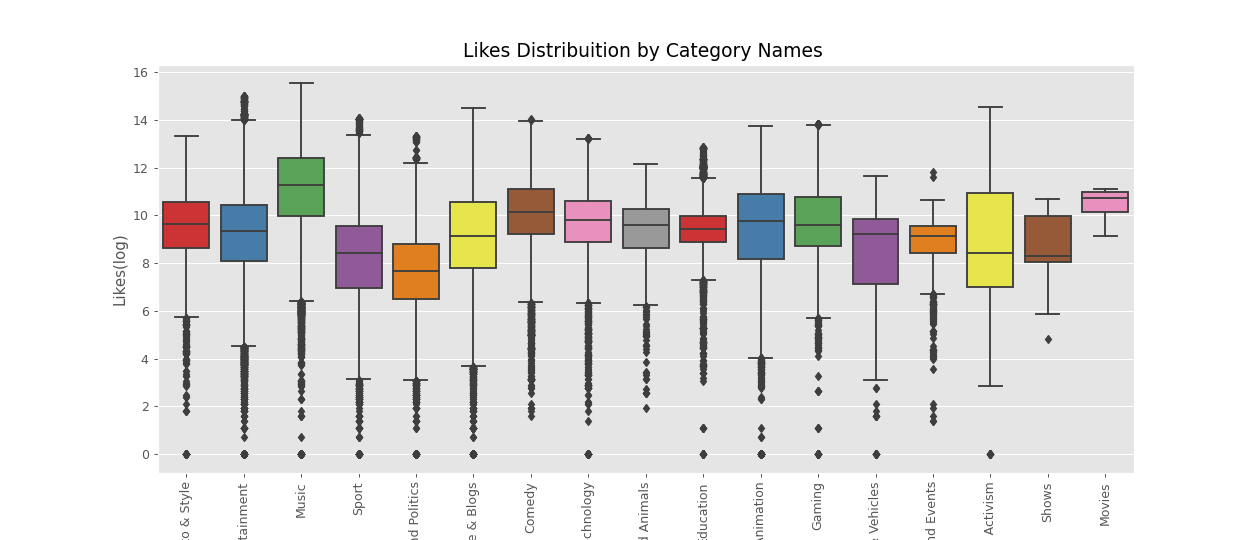

In [21]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likes_log', data=ENG_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Likes Distribuition by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


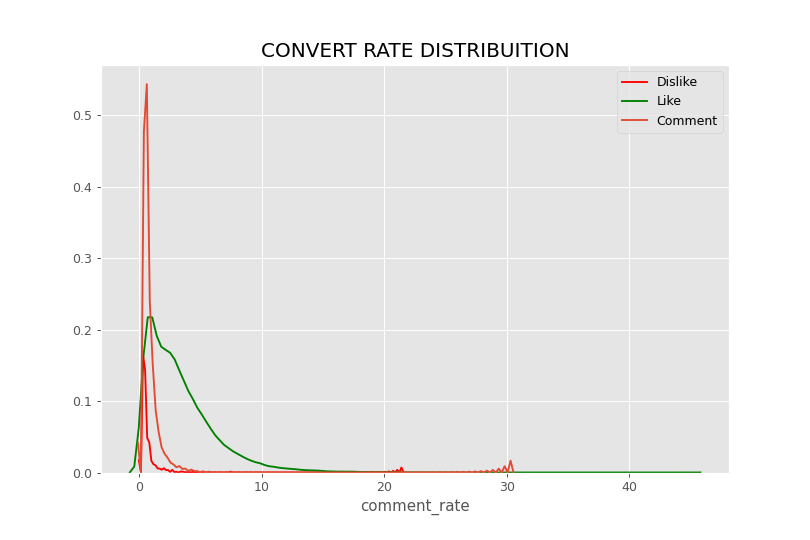

In [22]:
ENG_df['like_rate'] =  ENG_df['likes'] / ENG_df['views'] * 100
ENG_df['dislike_rate'] =  ENG_df['dislikes'] / ENG_df['views'] * 100
ENG_df['comment_rate'] =  ENG_df['comment_count'] / ENG_df['views'] * 100

plt.figure(figsize = (9,6))

g1 = sns.distplot(ENG_df['dislike_rate'], color='red',hist=False, label="Dislike")
g1 = sns.distplot(ENG_df['like_rate'], color='green',hist=False, label="Like")
g1 = sns.distplot(ENG_df['comment_rate'],hist=False,label="Comment")
g1.set_title('CONVERT RATE DISTRIBUITION', fontsize=16)
plt.legend()
plt.show()

TOP 5 Hour values
16    10889
17    10065
15     9176
18     7517
14     7374
Name: hour, dtype: int64


<IPython.core.display.Javascript object>


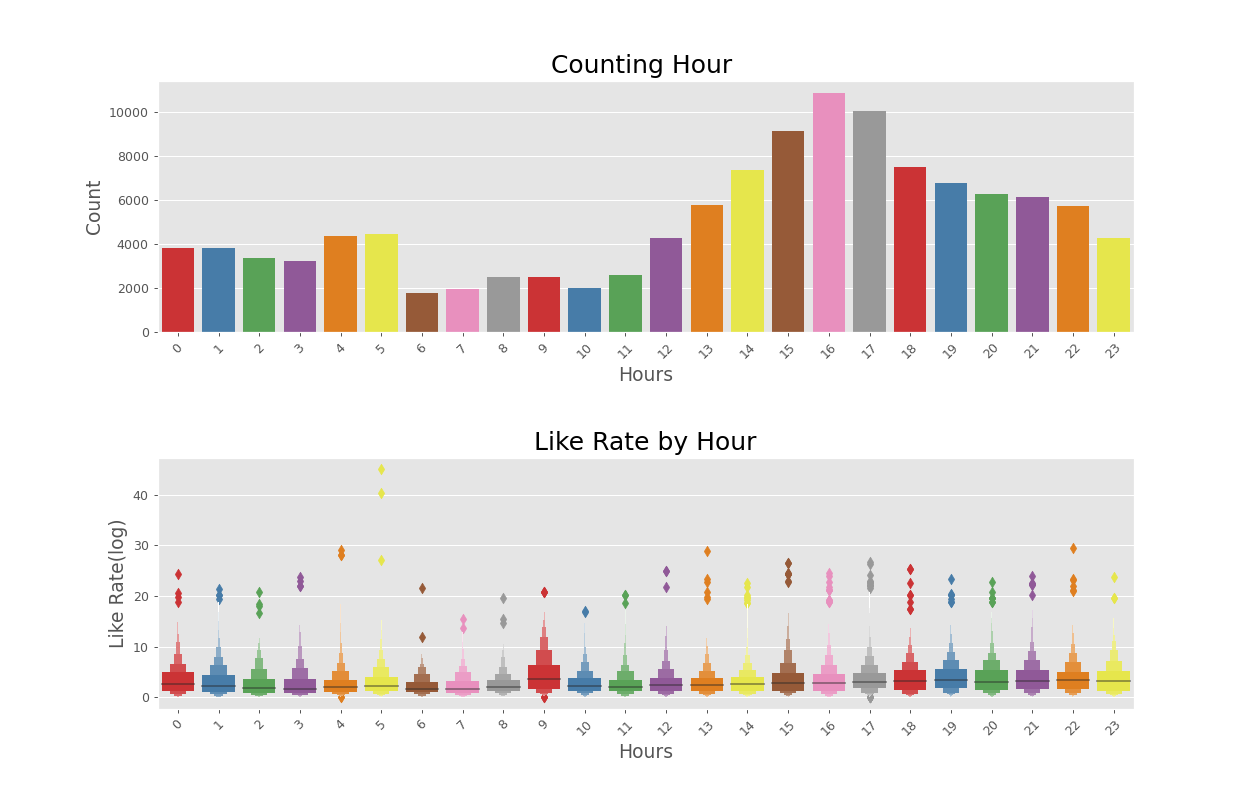

In [23]:
print("TOP 5 Hour values")
print(ENG_df['hour'].value_counts()[:5])

plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=ENG_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=ENG_df, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

<IPython.core.display.Javascript object>


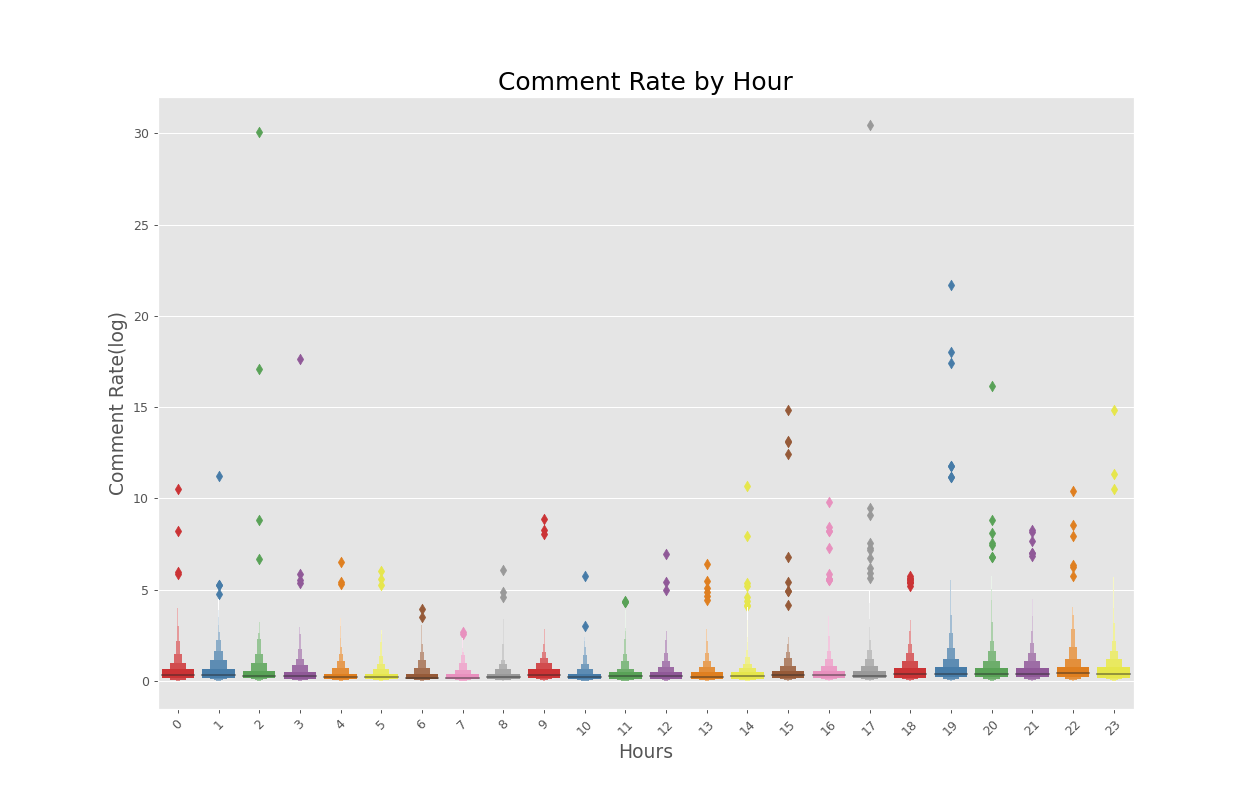

In [24]:
plt.figure(figsize = (14,9))

plt.subplot(111)
g2 = sns.lvplot(x='hour', y='comment_rate', data=ENG_df, palette="Set1")
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("Comment Rate by Hour", fontsize=20)
g2.set_xlabel("Hours", fontsize=15)
g2.set_ylabel("Comment Rate(log)", fontsize=15)

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                30318 non-null  object        
 1   trending_date           30318 non-null  datetime64[ns]
 2   title                   30318 non-null  object        
 3   channel_title           30318 non-null  object        
 4   publish_date            30318 non-null  datetime64[ns]
 5   category_id             30318 non-null  int64         
 6   publish_time            30318 non-null  object        
 7   tags                    30318 non-null  object        
 8   views                   30318 non-null  int64         
 9   likes                   30318 non-null  int64         
 10  dislikes                30318 non-null  int64         
 11  comment_count           30318 non-null  int64         
 12  thumbnail_link          30318 non-null  objec

<IPython.core.display.Javascript object>


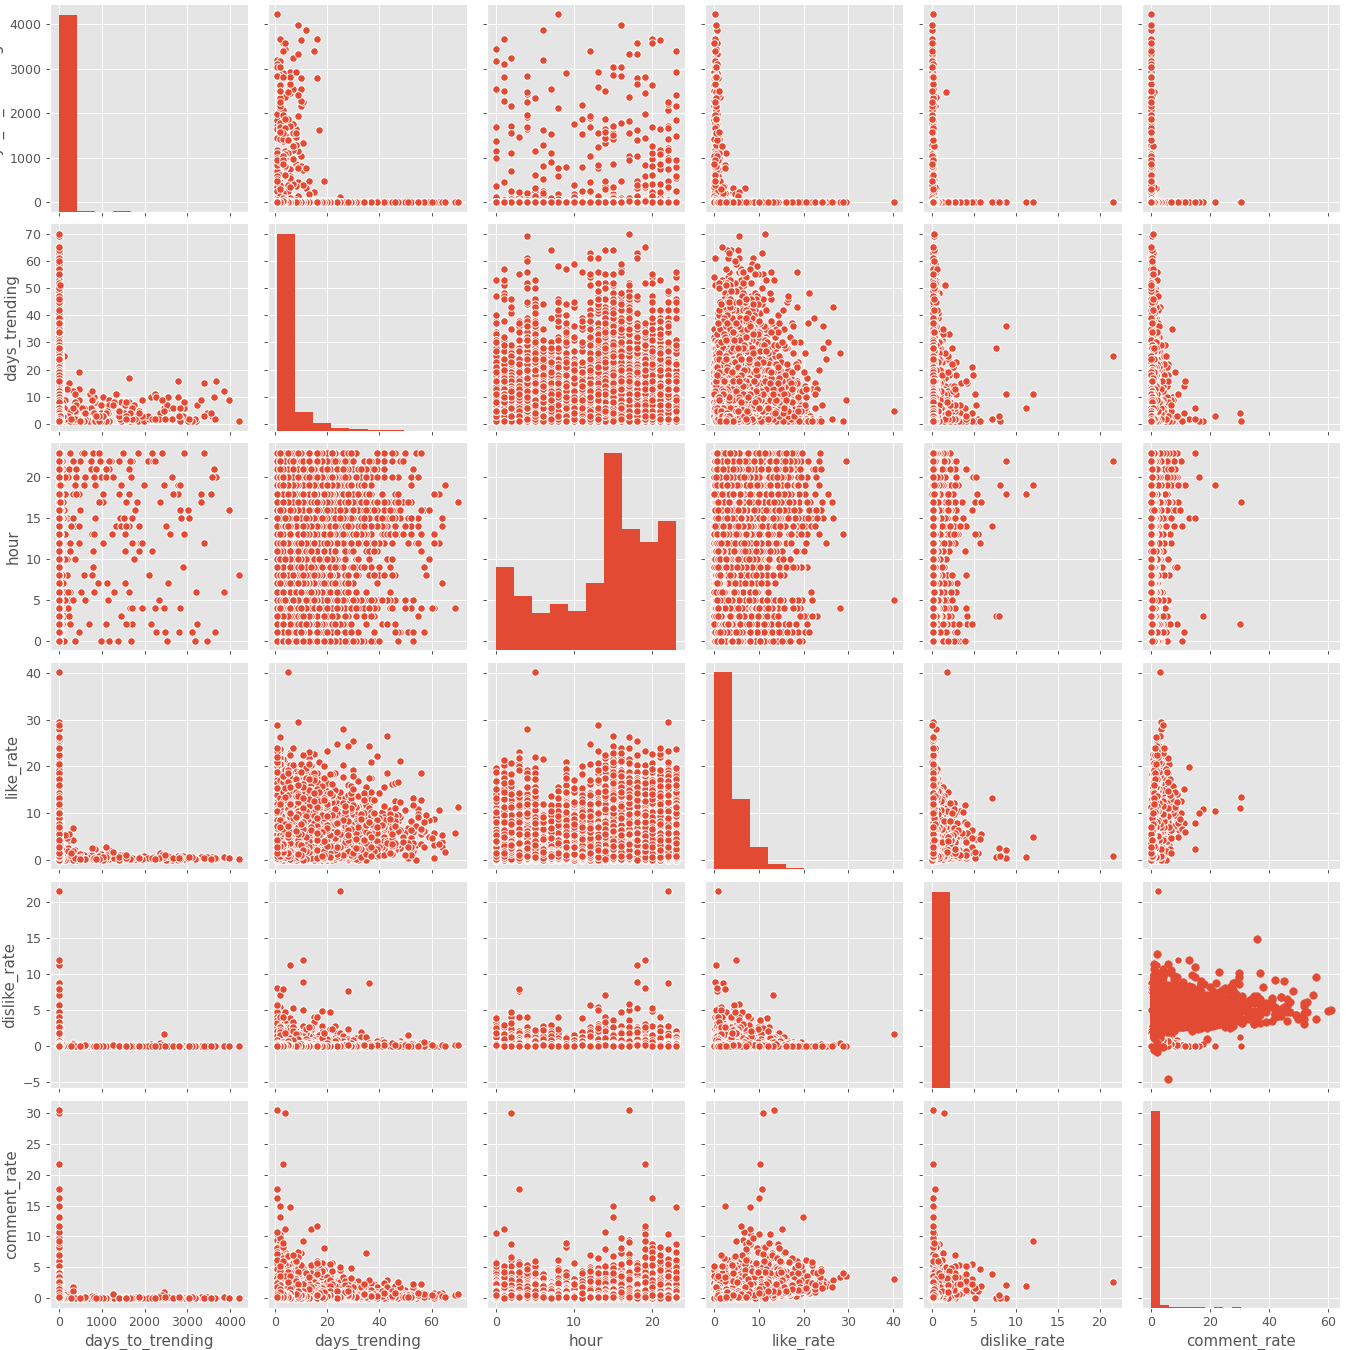

In [25]:
print(ENG_df_merge_first.info())

comp_df = pd.DataFrame(ENG_df_merge_first, columns = ['days_to_trending', 'days_trending', 'hour', 'like_rate', 'dislike_rate', 'comment_rate'])

sns.pairplot(comp_df)

The above pairplot reinforces the relationships highlighted through the previous SelectKBest features implementations. However, it further highlights the weakness of all numeric features' relationships with the number of days taken to reach trending, as well as the number of days a video will remain on trending.

There is such large variance in all relationships between all numeric features and the desired targets (days_to_trending and days_trendin). Therefore I believe that there is significant external influence beyond what can be measured numerically in this dataset. 

In [26]:
# I will be implementing, and testing an ElasticNet regressor for this problem, due to the issues faced in datasets 
# with a large number of variablesand the ways in which ridge regression can mitigate these issues as well as
# simplifying the model through the consideration of Lasso regression. A tradeoff between the two approaches will be considered using 
# hyperparameter tuning in order to increase the accuracy of the model.

#I will begin by learning a model to predict the days to trending based off of the selected best 4 relevant features for the considered target variable
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

X = comp_df.iloc[:,2:]
y = comp_df['days_to_trending']
#choose random state for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=24)

#creating the space for hyperparameter tuning, of the L1 penalty. This determines the tradeoff between L1 lasso regularisation and L2 ridge regularisation. to calculate the best penalty term for regularisation.
l1_ = np.linspace(0, 1, 50)
tune_grid = {'l1_ratio': l1_}

#regressor
elastic = ElasticNet()

#grid search object for hyperparameter tuning
grid_search = GridSearchCV(elastic, tune_grid, cv=5)

grid_search.fit(X_train, y_train)

#Now to predict on the test set, and compute scores.
y_pred = grid_search.predict(X_test)
r2 = grid_search.score(X_test, y_test)
meansq_error = mean_squared_error(y_test, y_pred)
print("ElasticNet l1 ratio: {}".format(grid_search.best_params_))
print("ElasticNet R squared: {}".format(r2))
print("ElasticNet MSE: {}".format(meansq_error))





ElasticNet l1 ratio: {'l1_ratio': 1.0}
ElasticNet R squared: 0.0030049240725705806
ElasticNet MSE: 16846.209085268532


The above results showed that, with a chosen lasso penalty of 1, and ridge penalty of 0. The R^2 is 0.0003 and mean squared error is 16846.21. This shows that the model, solely based on numeric features is extremely inaccurate and unreliable. In addition to this, 0.03% of the observable features are responsible for the variance in the target variable.

In [27]:
#I will implement the same model as above, but my objetive is to identify a relationship between the chosen features and the days a video remains on trending.
from sklearn.metrics import mean_squared_error

X = comp_df.iloc[:,2:]
y = comp_df['days_trending']
#choose random state for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=24)

#creating the space for hyperparameter tuning, of the L1 penalty. This determines the tradeoff between L1 lasso regularisation and L2 ridge regularisation. to calculate the best penalty term for regularisation.
l1_ = np.linspace(0, 1, 50)
tune_grid = {'l1_ratio': l1_}

#regressor
elastic = ElasticNet()

#grid search object for hyperparameter tuning
grid_search = GridSearchCV(elastic, tune_grid, cv=5)

grid_search.fit(X_train, y_train)

#Now to predict on the test set, and compute scores.
y_pred = grid_search.predict(X_test)
r2 = grid_search.score(X_test, y_test)
meansq_error = mean_squared_error(y_test, y_pred)
print("ElasticNet l1 ratio: {}".format(grid_search.best_params_))
print("ElasticNet R squared: {}".format(r2))
print("ElasticNet MSE: {}".format(meansq_error))


ElasticNet l1 ratio: {'l1_ratio': 0.0}
ElasticNet R squared: 0.0431404570697963
ElasticNet MSE: 36.15104018357971


As can be seen above, this predictor is far more accurate than the previous implementation. The features which have been observed (like rate, dislike rate, comment rate, and hour uploaded) are stronger in predicting the number of days a video will remain trending once it begins trending.



In [28]:
#now I will observe whether there appears to be any meaningful relationship between the days_to_trending and the days_trending.
#My expectation is that the sooner a video reaches the trending page (lower days_to_trending), the longer it will remain trending (higher days_trending)

X_days_to = comp_df['days_to_trending']
y_days = comp_df['days_trending']

X_days_train, X_days_test, y_days_train, y_days_test = train_test_split(X, y, test_size = 0.3, random_state=24)


#create regressor
linReg = LinearRegression()

#fit model to data
linReg.fit(X_days_train, y_days_train)

#predict over prediction space
y_pred_days = linReg.predict(X_days_test)

r2_days = linReg.score(X_days_test, y_days_test)
print("R squared: {}".format(r2_days))

MSE_days =  mean_squared_error(y_days_test, y_pred_days)
print("ElasticNet MSE: {}".format(meansq_error))

plt.scatter(y_days_test, y_pred_days)
plt.xlabel('Days to trending')
plt.ylabel('Days on trending')
plt.show()


R squared: 0.05307174542716653
ElasticNet MSE: 36.15104018357971


The above diagram shows that, videos tend to trend for roughly the same amount of time regardless of the time taken to reach the trending page. Therefore, there is no relevant relationship between the days taken to reach trending, and the number days a video remains on trending.

In [29]:
'''
Next, I plan to use unsupervised methods to observe the relationships between days_to_trending and days_on_trending, based on category.
'''

'\nNext, I plan to use unsupervised methods to observe the relationships between days_to_trending and days_on_trending, based on category.\n'

In [30]:
ENG_df_merge_first['category_name'] = np.nan

ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 1),"category_name"] = 'Film and Animation'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 2),"category_name"] = 'Autos & Vehicles'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 10),"category_name"] = 'Music'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 15),"category_name"] = 'Pets and Animals'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 17),"category_name"] = 'Sport'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 18),"category_name"] = 'Short Movies'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 19),"category_name"] = 'Travel and Events'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 20),"category_name"] = 'Gaming'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 21),"category_name"] = 'Videoblogging'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 22),"category_name"] = 'People & Blogs'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 23),"category_name"] = 'Comedy'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 24),"category_name"] = 'Entertainment'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 25),"category_name"] = 'News and Politics'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 26),"category_name"] = 'How to & Style'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 27),"category_name"] = 'Education'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 28),"category_name"] = 'Science and Technology'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 30),"category_name"] = 'Movies'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 31),"category_name"] = 'Anime/Animation'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 32),"category_name"] = 'Action/Adventure'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 33),"category_name"] = 'Classics'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 34),"category_name"] = 'Comedy'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 35),"category_name"] = 'Documentary'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 36),"category_name"] = 'Drama'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 37),"category_name"] = 'Family'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 38),"category_name"] = 'Foreign'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 39),"category_name"] = 'Horror'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 40),"category_name"] = 'Sci-Fi/Fantasy'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 41),"category_name"] = 'Thriller'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 42),"category_name"] = 'Shorts'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 43),"category_name"] = 'Shows'
ENG_df_merge_first.loc[(ENG_df_merge_first["category_id"] == 44),"category_name"] = 'Trailers'

print(ENG_df_merge_first.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                30318 non-null  object        
 1   trending_date           30318 non-null  datetime64[ns]
 2   title                   30318 non-null  object        
 3   channel_title           30318 non-null  object        
 4   publish_date            30318 non-null  datetime64[ns]
 5   category_id             30318 non-null  int64         
 6   publish_time            30318 non-null  object        
 7   tags                    30318 non-null  object        
 8   views                   30318 non-null  int64         
 9   likes                   30318 non-null  int64         
 10  dislikes                30318 non-null  int64         
 11  comment_count           30318 non-null  int64         
 12  thumbnail_link          30318 non-null  objec

In [31]:
from sklearn.cluster import KMeans

cat_num = ENG_df_merge_first['category_name'].nunique()
model_1 = KMeans(n_clusters = cat_num)


obs_1 = pd.concat([ENG_df_merge_first['days_trending'], ENG_df_merge_first['days_to_trending'], ENG_df_merge_first['category_name']], axis=1, keys=['days_trending', 'days_to_trending', 'category_name'])

msk = np.random.rand(len(obs_1)) < 0.8
train = obs_1[msk]
test = obs_1[~msk]

train_1 = train.iloc[:,:2]
test_1 = test.iloc[:,:2]
model_1.fit(train_1)

clust_label = model_1.predict(test_1)

#print(len(clust_label))
print(test_1)

        days_trending  days_to_trending
0                  18                 4
59                  1                 3
79                  1                 4
113                11                 3
187                14                 5
...               ...               ...
120635              2                 1
120650              6                 1
120674              6                 3
120722              3                 2
120742              1                 0

[6143 rows x 2 columns]


In [32]:
print(test_1)

xs_1 = test_1.iloc[:,0]
ys_1 = test_1.iloc[:,1]

print(xs_1)
print(ys_1)

        days_trending  days_to_trending
0                  18                 4
59                  1                 3
79                  1                 4
113                11                 3
187                14                 5
...               ...               ...
120635              2                 1
120650              6                 1
120674              6                 3
120722              3                 2
120742              1                 0

[6143 rows x 2 columns]
0         18
59         1
79         1
113       11
187       14
          ..
120635     2
120650     6
120674     6
120722     3
120742     1
Name: days_trending, Length: 6143, dtype: int64
0         4
59        3
79        4
113       3
187       5
         ..
120635    1
120650    1
120674    3
120722    2
120742    0
Name: days_to_trending, Length: 6143, dtype: int64


<IPython.core.display.Javascript object>


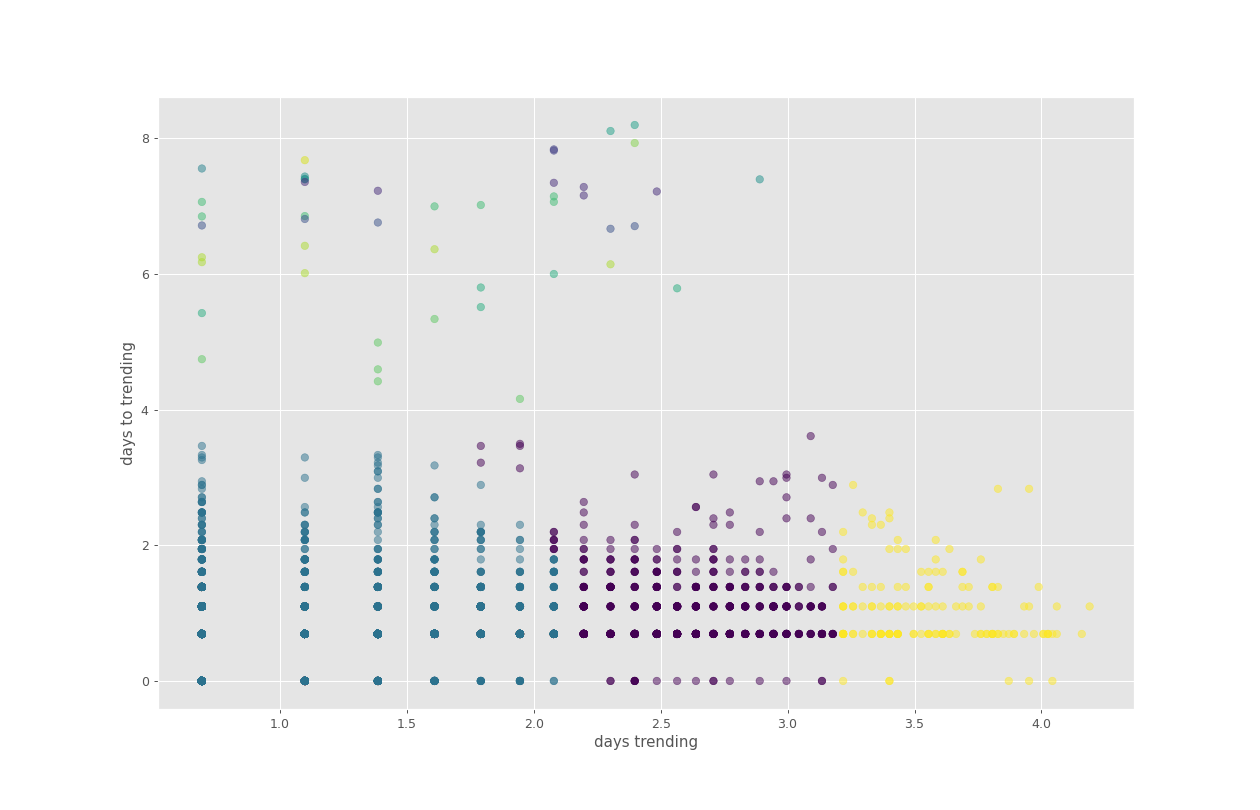

In [33]:
plt.figure(figsize = (14,9))

plt.subplot(111)
plt.scatter(np.log(xs_1+1), np.log(ys_1 + 1), c=clust_label, alpha=0.5)
plt.xlabel('days trending')
plt.ylabel('days to trending')
plt.show()

In [34]:
# will look at distribution of days trending vs days to trend, for each category respectively.
centroids = model_1.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

<IPython.core.display.Javascript object>


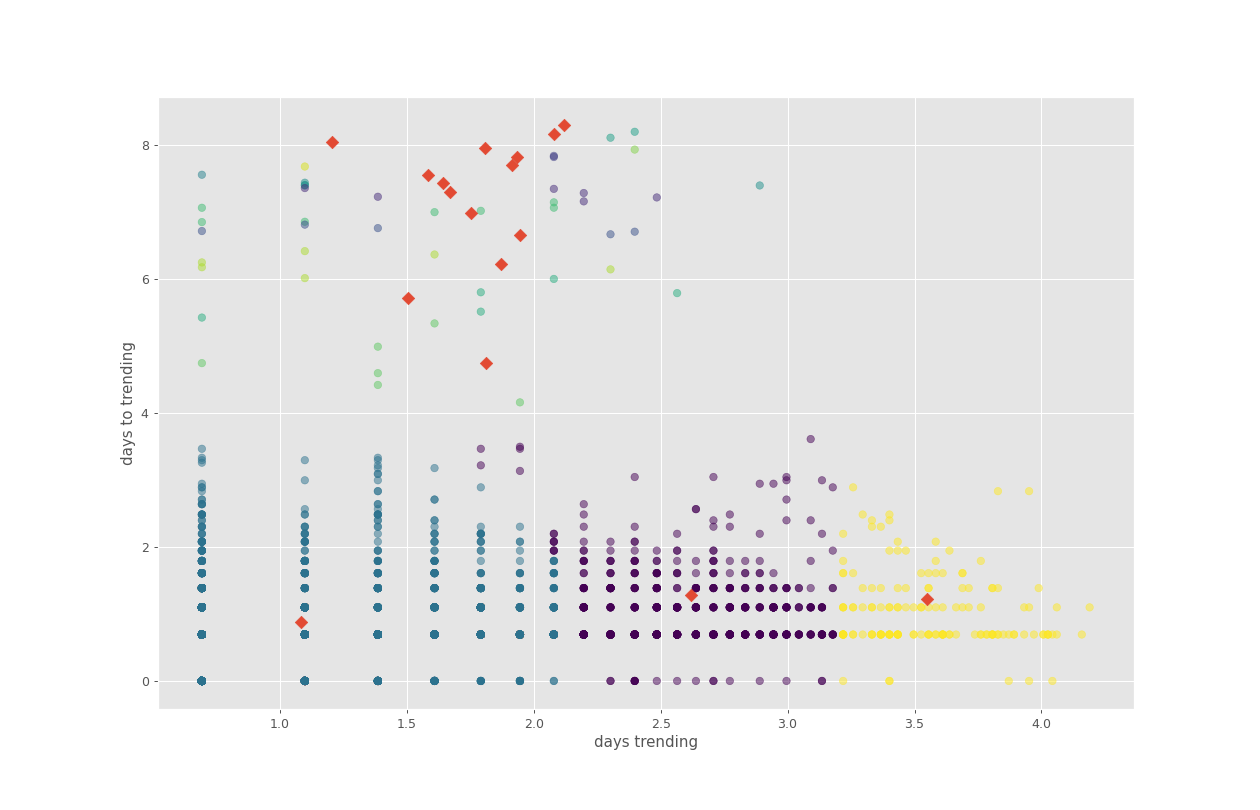

In [35]:
plt.figure(figsize = (14,9))

plt.subplot(111)
plt.scatter(np.log(xs_1+1), np.log(ys_1 + 1), c=clust_label, alpha=0.5)
plt.scatter(np.log(centroids_x+1) , np.log(centroids_y + 1), marker='D', s=50)
plt.xlabel('days trending')
plt.ylabel('days to trending')

plt.show()

In [36]:
inertia_1 = []

inertia_1.append(model_1.inertia_)

print(inertia_1)

'''
sum of squared distances of samples to their closest cluster center is 1090899.696, highlighting a great variance
throughout the dataset within categories, regarding the relationship between days_to_trending and days_trending.
'''

#plt.plot('17', inertia_1, '-o')
#plt.xlabel('number of clusters, k')
#plt.ylabel('inertia')
#plt.xticks(ks)
#plt.show()

[1061354.1057265645]


'\nsum of squared distances of samples to their closest cluster center is 1090899.696, highlighting a great variance\nthroughout the dataset within categories, regarding the relationship between days_to_trending and days_trending.\n'

<IPython.core.display.Javascript object>


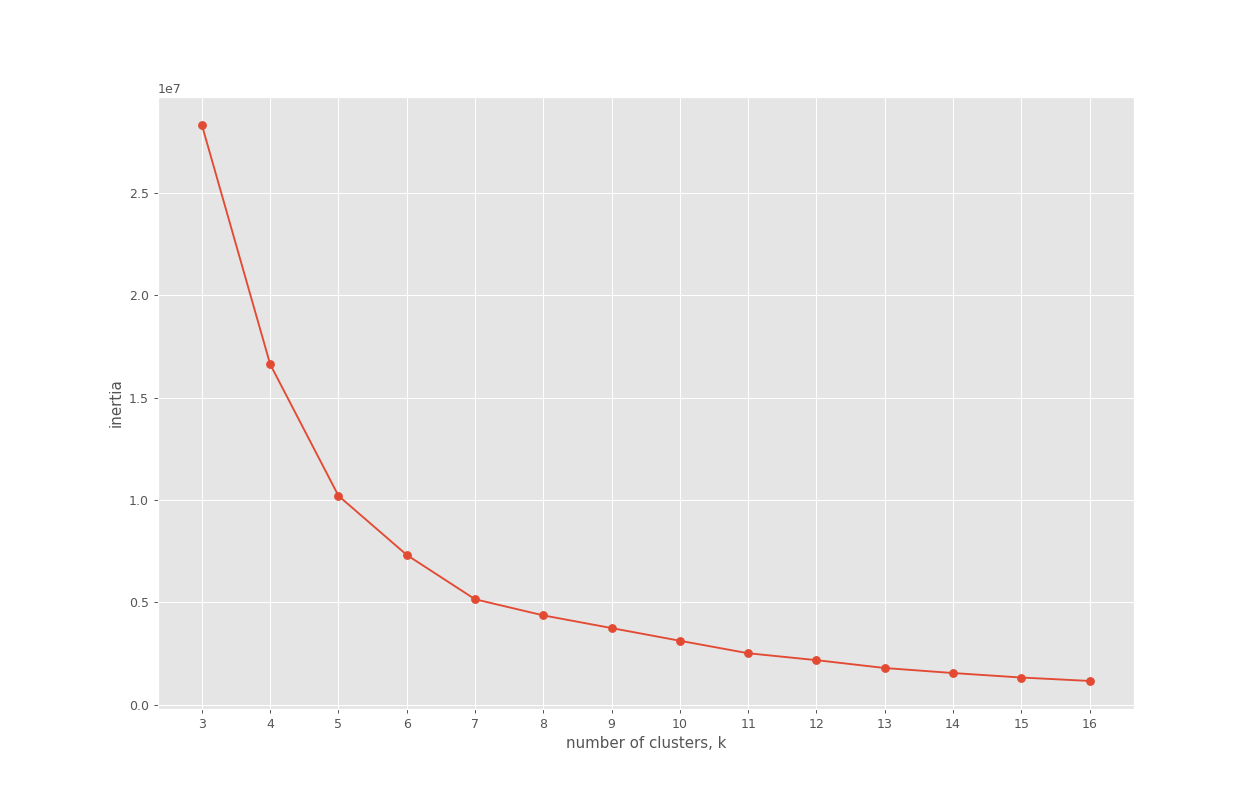

In [78]:
ks = range(3, 17)
inertias_2 = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model_2 = KMeans(n_clusters=k)
    
    # Fit model to samples
    model_2.fit(train_1)
    
    # Append the inertia to the list of inertias
    inertias_2.append(model_2.inertia_)

plt.figure(figsize = (14,9))

plt.subplot(111)
plt.plot(ks, inertias_2, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Although it appears that the inertia begins to slow around k=7 clusters, there are infact 17 categories to identify. Therefore this further supports previous evidence which highlights that there is no clear relationship between days_to_trending and days_trending, and further, this relationship does not arise from considering each category indidivually.

In [79]:


df = pd.DataFrame({'labels': clust_label, 'categories': test['category_name']})

#Create crosstab in order to determine the number of times a sample within a cluster coincides with each label.
ct = pd.crosstab(df['labels'], df['categories'])

print(ct)




categories  Autos & Vehicles  Comedy  Education  Entertainment  \
labels                                                           
0                          4      57         21            185   
2                          0       2          0              1   
3                          0       0          0              0   
4                          0       0          1              1   
6                         57     420        128           1758   
7                          0       0          0              0   
8                          0       0          0              1   
9                          0       0          0              0   
10                         0       0          1              1   
11                         0       0          0              2   
12                         0       1          0              0   
13                         0       0          0              1   
14                         1       1          0              1   
15        

The above cross tabulation shows that, for all categories, clustering by days_to_trending vs days_trending showed no variety between categories. All categories had the majority of their videos assigned to label 15, with some outliers being assigned to other labels in small numbers.

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer


#I will attempt to see if standardisation improves clustering.

std_scaler = StandardScaler()

pipe = make_pipeline(std_scaler, model_1)

pipe.fit(train_1)
std_labels = pipe.predict(test_1)
# Create a DataFrame with labels and species as columns: df
std_df = pd.DataFrame({'labels': std_labels, 'categories': test['category_name']})

# Create crosstab std_ct

std_ct = pd.crosstab(std_df['labels'], std_df['categories'])

#print(std_ct)
print(std_ct.sort_values('labels'))



categories  Autos & Vehicles  Comedy  Education  Entertainment  \
labels                                                           
0                          5      52         18            171   
1                          0       0          0              1   
2                          2      22          9             82   
3                          0       1          1              7   
4                         32     184         72           1000   
5                          0       0          1              3   
6                          1       8          1             22   
7                          0       0          0              1   
8                          0       0          0              1   
9                          3      31         11             77   
10                         0       3          0              6   
11                         0       2          0              2   
12                        18     167         36            556   
13        

<IPython.core.display.Javascript object>


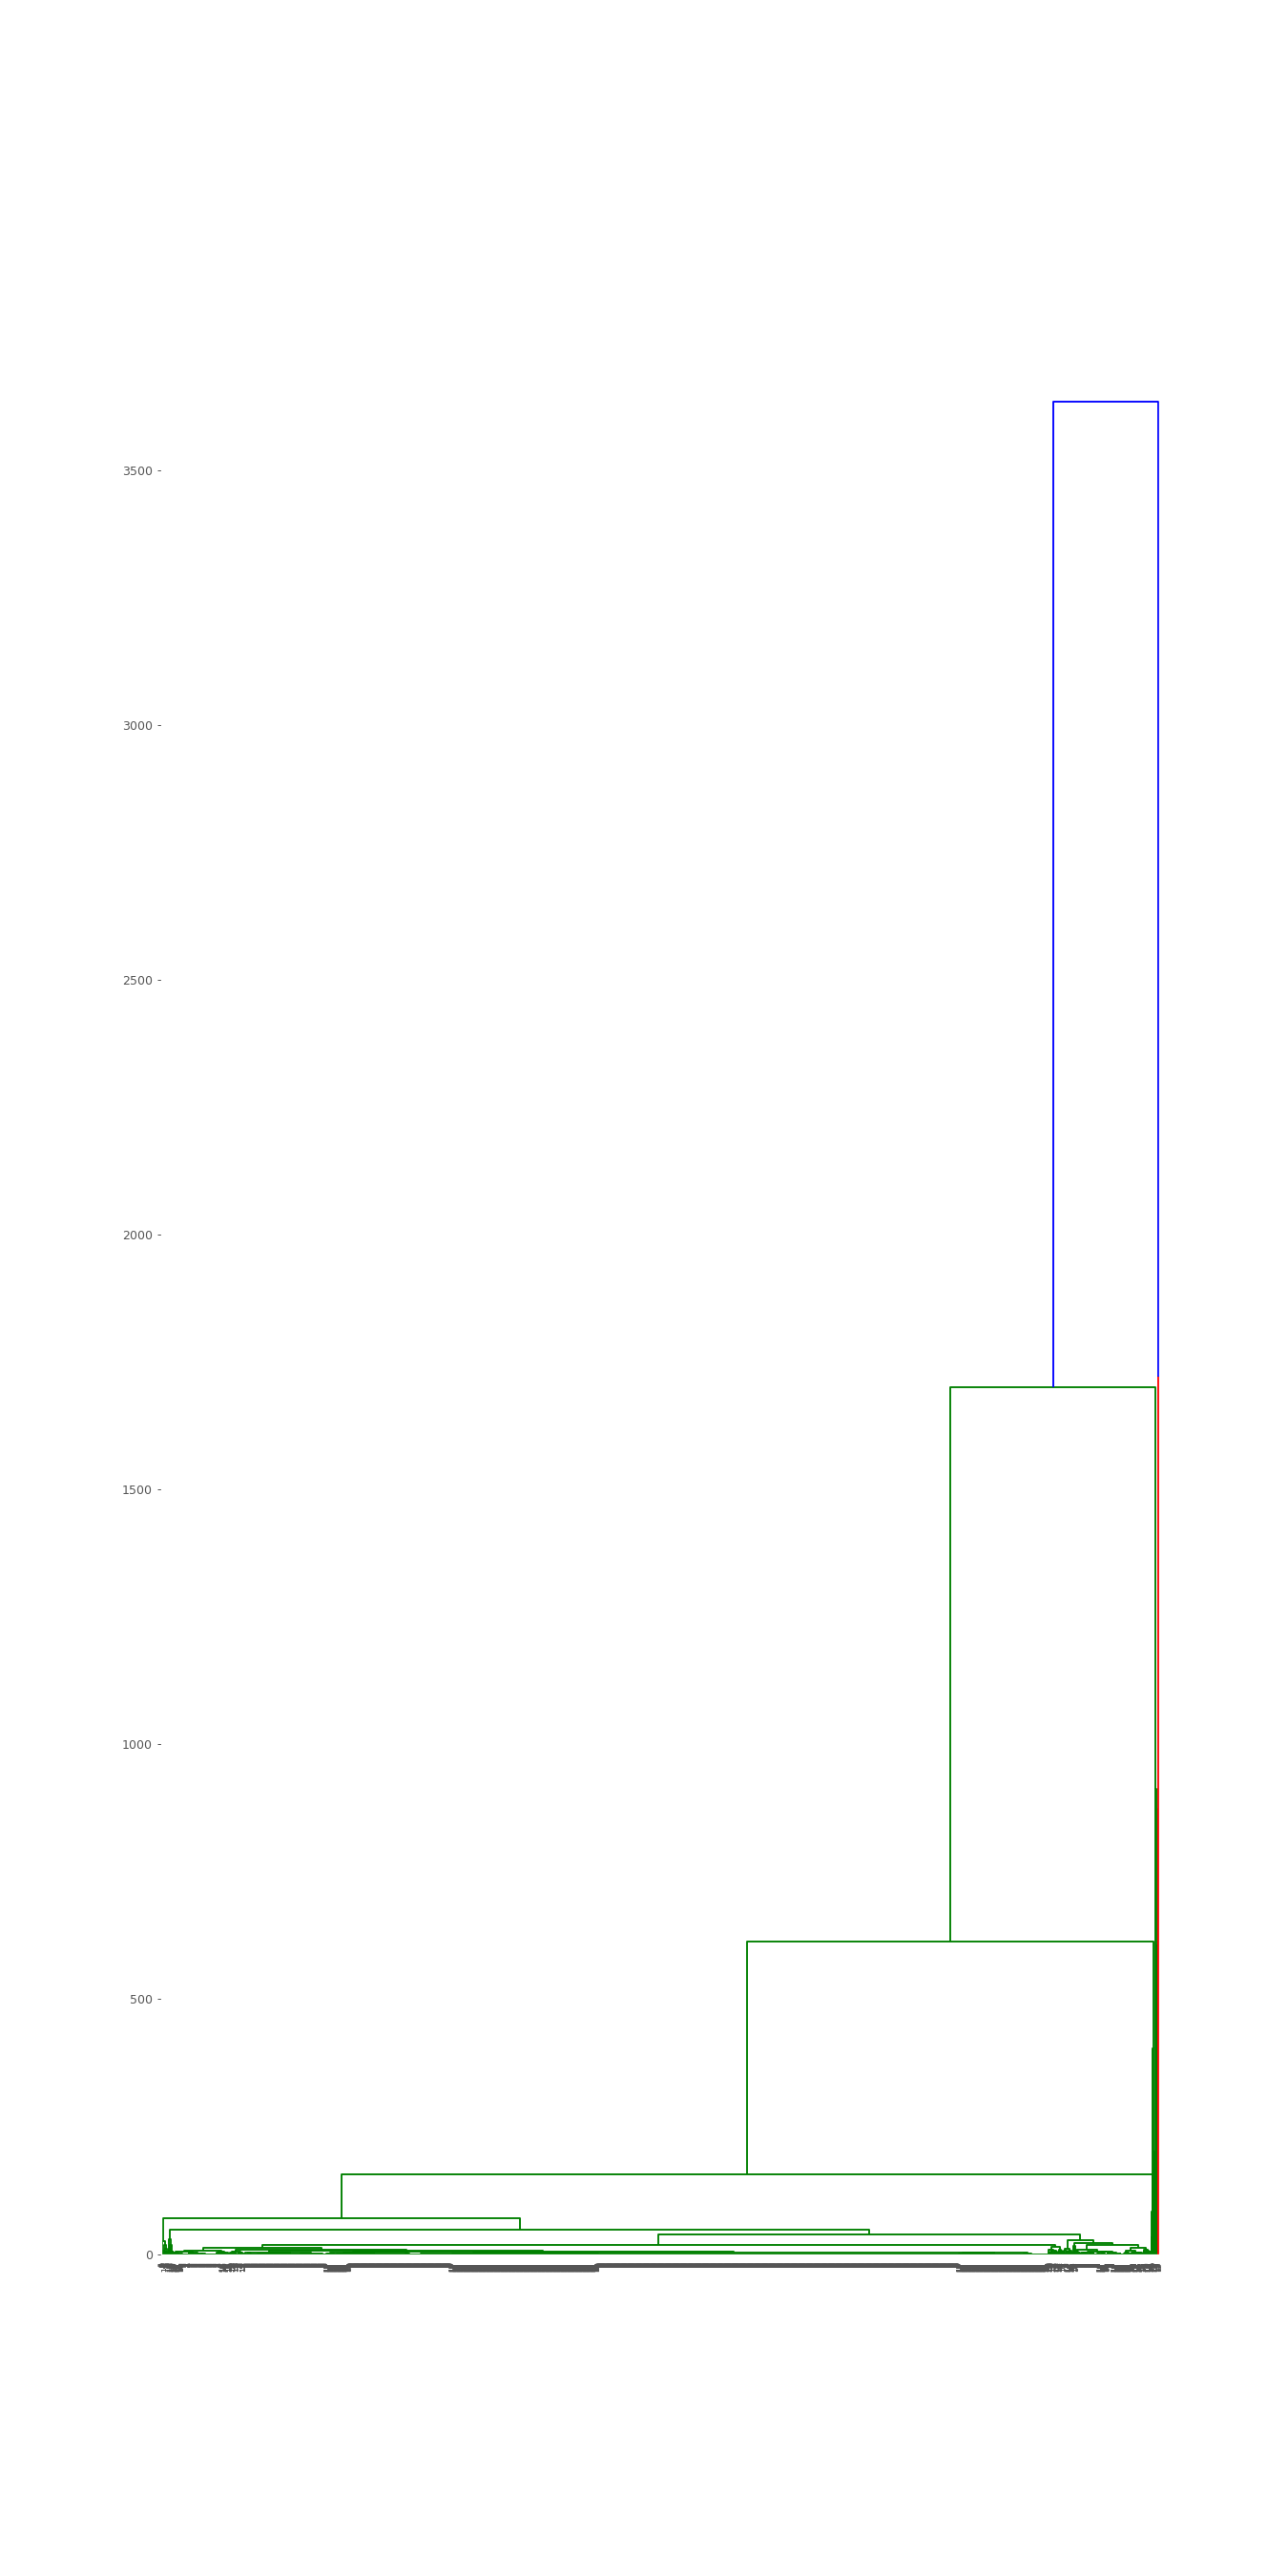

In [77]:
from scipy.cluster.hierarchy import linkage, dendrogram

links = linkage(test_1, method='complete')

plt.figure(figsize = (15,30))
plt.subplot(111)
dendrogram(links,
           labels=std_labels,
           leaf_rotation=90,
           leaf_font_size=6,
)

plt.show()